# Jupyter Notebook - Ransomware report use cases 1

Copyright © 2021 Google

Welcome to our Ransomware in a Global Context Jupyter notebook!

You can find this and other very interesting posts in our [blog](https://blog.virustotal.com/).

In [2]:
#@markdown Please, insert your VT API Key*:

API_KEY = ''  #@param  {type: "string"}

#@markdown **The API key should have Premium permissions, otherwise some of the use cases might not provide the expected results.*

#@markdown 




---
---



In [ ]:
!pip install vt-py nest_asyncio

# Use Case: Distribution vectors extraction





Given a couple of searches like these ones:

       engines:gandcrab fs:2020-02-01+ fs:2020-05-01- (type:peexe or type:pedll) tag:exploit (have:compressed_parents OR have:execution_parents OR have:pcap_parents OR have:email_parents)
       engines:gandcrab fs:2020-02-01+ fs:2020-05-01- (type:peexe or type:pedll) have:in_the_wild

You can easily extract the distribution vectors of those matches thanks to the different relationships related to those observables. More concretely, we are going to focus on these relationships:

*   [itw_ips](https://docs.virustotal.com/reference/itw_ips)
*   [itw_urls](https://docs.virustotal.com/reference/files-itw_urls)
*   [itw_domains](https://docs.virustotal.com/reference/files-itw_domains)
*   [compressed_parents](https://docs.virustotal.com/reference/files-compressed_parents)
*   [execution_parents](https://docs.virustotal.com/reference/files-execution_parents)
*   [pcap_parents](https://docs.virustotal.com/reference/files-pcap_parents)
*   [email_parents](https://docs.virustotal.com/reference/files-email_parents)

Please note that as the search is looking for old files, the **retrospection's limitation** that you might have can affect to the number of results that this report provides.


## Workflow:

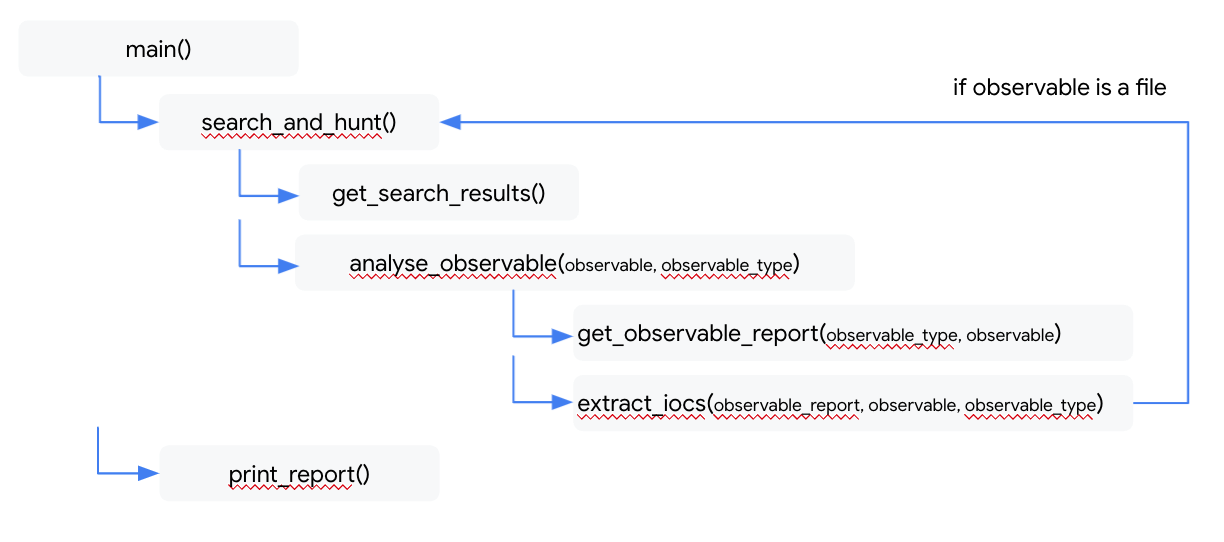

## Script:


In [ ]:
import base64
import hashlib
import json
import requests

QUERIES = [
    "engines:gandcrab fs:2020-02-01+ fs:2020-05-01- (type:peexe or type:pedll) tag:exploit (have:compressed_parents OR have:execution_parents OR have:pcap_parents OR have:email_parents)",
    "engines:gandcrab fs:2020-02-01+ fs:2020-05-01- (type:peexe or type:pedll) have:in_the_wild"
]
RELATIONSHIPS = ["itw_ips", "itw_urls", "itw_domains", "compressed_parents", "execution_parents", "pcap_parents", "email_parents"]
separator = ","
RELATIONSHIPS_URL = separator.join(RELATIONSHIPS)
detected_domains = {}
detected_ips = {}
detected_urls = {}
detected_files = {}
analyzed_objects = []


def get_search_results(query, vt_client):
  """Execute the search and return the results."""
  url = "/intelligence/search"
  results = vt_client.iterator(url, params={"query": query, "relationships": RELATIONSHIPS_URL})
  
  return results


def analyse_observable(observable, observable_type, vt_client):
  if observable not in analyzed_objects:
    observable_report = get_observable_report(observable,observable_type, vt_client)
    if observable_report:
      extract_iocs(observable, observable_type, vt_client, observable_report)
  else:
    extract_iocs(observable, observable_type, vt_client)


def get_observable_report(observable, observable_type, vt_client):
  """Get the observable's intelligence report from VirusTotal."""

  endpoint = {"url": "urls", "domain": "domains", "ip_address": "ip_addresses", "file": "files"}
  if observable_type == "url":
    observable = base64.urlsafe_b64encode(observable.encode()).decode().strip("=")   
  endpoint = endpoint[observable_type]
  if observable_type == "file":
    results = vt_client.get_object(f"/{endpoint}/{observable}?relationships={RELATIONSHIPS_URL}")
  else:
    results = vt_client.get_object(f"/{endpoint}/{observable}?relationships=votes")
  return results



def add_observable(iocs_dict, observable, positives=False):
  """Check if the observable was already seen before adding it into the final report."""

  if observable not in iocs_dict:
    iocs_dict[observable] = {}
    iocs_dict[observable]["positives"] = positives
    iocs_dict[observable]["relatives"] = 1
  else:
    iocs_dict[observable]["relatives"] += 1

  if observable not in analyzed_objects:
    analyzed_objects.append(observable)
  return iocs_dict


def extract_iocs(observable, observable_type, vt_client, observable_report=False):
  """Add the malicious relationships into the list of detected ovservables."""

  global detected_ips
  global detected_urls
  global detected_domains
  global detected_files

  if observable_report:
    positives = observable_report.last_analysis_stats["malicious"]
  else:
    try:
      positives = detected_files[observable]["positives"]
    except:
      positives = False
  if observable_type == "ip_address":
    detected_ips = add_observable(detected_ips, observable, positives)
  elif observable_type == "url":
    detected_urls = add_observable(detected_urls, observable, positives)
  elif observable_type == "domain":
    detected_domains = add_observable(detected_domains, observable, positives)
  else:
    detected_files = add_observable(detected_files, observable, positives)
    if detected_files[observable]["relatives"] == 1:
      search_and_hunt(vt_client, observable_report)
  return


def search_and_hunt(vt_client, observable_report=False):
  """Iterate over the queries and get matches.

    Then, analyze the relationships of those matches.
  """

  if observable_report:
    results = observable_report
    for relationship in RELATIONSHIPS:
      if results.relationships[relationship]["data"]:
        for hit in results.relationships[relationship]["data"]:
          observable_type = hit["type"]
          observable = hit["id"]
          if observable_type == "url":
            observable = hit["context_attributes"]["url"]
          analyse_observable(observable, observable_type, vt_client)


  else:
    for query in QUERIES:
        results = get_search_results(query, vt_client)
        for result in results:
          match = result.id
          for relationship in RELATIONSHIPS:
            if result.relationships[relationship]["data"]:
              for hit in result.relationships[relationship]["data"]:
                observable_type = hit["type"]
                observable = hit["id"]
                if observable_type == "url":
                  observable = hit["context_attributes"]["url"]
                analyse_observable(observable, observable_type, vt_client) 


def print_report():
  """Iterate over the detected observables and print the results."""

  def print_header():
    row = ["Positives","Relatives","VT Link","Observable"]
    print("{: ^15} {: <15} {: ^20} {: >100}".format(*row))
    print("_"*200)

  def print_dict(d,type):
    d2 = {}
    for item in d:
      d2[item] = d[item]["relatives"]

    top_view = [ (v,k) for k,v in d2.items() ]
    top_view.sort(reverse=True)

    for items in top_view:
      observable = items[1]
      if type == "url":
        encoded_url = hashlib.sha256(items[1].encode()).hexdigest()
        row = [d[observable]["positives"],d[observable]["relatives"],"https://www.virustotal.com/gui/" + type + "/"+encoded_url,observable]
      else:
        row = [d[observable]["positives"],d[observable]["relatives"],"https://www.virustotal.com/gui/" + type + "/"+observable,observable]
      print("{: ^10} {:^17} {: <110} {: <70}".format(*row))

  print("\n\tDISTRIBUTION VECTORS REPORT\n")

  print("\n#1: FILES\n")
  print_header()
  print_dict(detected_files, "file")

  print("\n##2: DOMAINS\n")
  print_header()
  print_dict(detected_domains, "domain")

  print("\n#3: URLS\n")
  print_header()
  print_dict(detected_urls, "url")

  print("\n#4: IP ADDRESSES\n")
  print_header()
  print_dict(detected_ips, "ip-address")

  print("\n")


def main():
  vt_client = vt.Client(API_KEY)
  search_and_hunt(vt_client)
  print_report()

main()

# Use Case: Ports and IP extraction



In this use case we are going to focus on the lateral movements prevention. 

In order to this we will make use of the behavioural network reports.

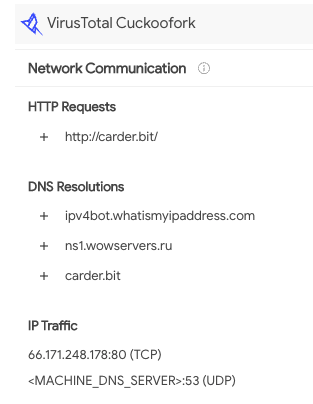

## Script:

In [ ]:
import nest_asyncio
nest_asyncio.apply()
import base64
import requests
import vt

QUERIES = [
    "engines:gandcrab fs:2020-02-01+ fs:2020-05-01- (type:peexe or type:pedll) tag:exploit have:behaviour_network"
]
RELATIONSHIPS = ["behaviours"]
separator = ","
RELATIONSHIPS_URL = separator.join(RELATIONSHIPS)
extractions = {}
verdicts = {}
analyzed_objects = []


def get_search_results(query, vt_client):
  """Execute the search and return the results."""
  url = "/intelligence/search"
  results = vt_client.iterator(url, params={"query": query, "relationships": RELATIONSHIPS_URL})
  
  return results

def analyse_observable(observable, observable_type, vt_client):
  if observable not in analyzed_objects:
    analyzed_objects.append(observable)
    observable_report = get_observable_report(observable, observable_type, vt_client)
    if observable_report:
      extract_iocs(observable, observable_report, vt_client)


def get_observable_report(observable, observable_type, vt_client):
  """Get the observable's intelligence report from VirusTotal."""

  endpoint = {"file_behaviour": "file_behaviours", "ip_address": "ip_addresses"}
  endpoint = endpoint[observable_type]
  results = vt_client.get_object(f"/{endpoint}/{observable}")
  return results


def extract_iocs(observable, observable_report, vt_client):
  """Add the malicious relationships into the list of detected ovservables."""

  global extractions
  global verdicts

  if hasattr(observable_report, "ip_traffic"):
    comms = observable_report.ip_traffic

    for comm in comms:
      try:
        protocol = comm["transport_layer_protocol"]
      except:
        protocol = "Unknown"
      ip = comm["destination_ip"]
      port = comm["destination_port"]
      hash = observable[:64]

      if hash not in extractions:
        extractions[hash] = {"ports":[], "ips":[], "protocols":[]}
      if port not in extractions[hash]["ports"]:
        extractions[hash]["ports"].append(port)
        verdicts[port] = "N/A"
      if ip not in extractions[hash]["ips"]:
        extractions[hash]["ips"].append(ip)
        if "DNS" in ip:
          positives = "N/A"
        else:
          observable_report = get_observable_report(ip, "ip_address", vt_client)
          positives = observable_report.last_analysis_stats["malicious"]
        verdicts[ip] = positives
      if protocol not in extractions[hash]["protocols"]:
        extractions[hash]["protocols"].append(protocol)
        verdicts[protocol] = "N/A"

  return


def search_and_hunt(vt_client):
  for query in QUERIES: 
    results = get_search_results(query, vt_client)
    for result in results:
      match = result.id
      for relationship in RELATIONSHIPS:
        if result.relationships[relationship]["data"]:
          for hit in result.relationships[relationship]["data"]:
            observable_type = hit["type"]
            observable = hit["id"]
            analyse_observable(observable, observable_type, vt_client)


def print_report():
  elements = ["ports", "ips", "protocols"]
  for e in elements:
    get_top_list(e)


def get_top_list(element):
  e_list = []
  for hash in extractions:
    e_list = list(set(e_list) | set(extractions[hash][element]))

  e_top = {}
  for hash in extractions:
    for e in e_list:
      if e not in e_top:
        e_top[e] = 0
      if e in extractions[hash][element]:
        e_top[e] += 1

  print("\nTOP " + element + "\n" + "_"*100 + "\n")
  top_view = [ (v,k) for k,v in e_top.items() ]
  top_view.sort(reverse=True)
  for matches,observable in top_view:
      row = [str(verdicts[observable]), observable, "Number of matches: ", matches]
      print("\tPositives: {: >8} {: ^20} {: >20} {: >3}".format(*row))


def main():
  vt_client = vt.Client(API_KEY)
  search_and_hunt(vt_client)
  print_report()

main()

# Use Case: Geographical Distribution

In this use case we will iterate over all the matches of our initial search:


In [ ]:
#@markdown

VTI_SEARCH = 'engines:gandcrab fs:2020-02-01+ fs:2020-05-01- (type:peexe or type:pedll) tag:exploit'  #@param  {type: "string"}

#@markdown 

The difference now is that we will take a look to the Submissions tab in order to indentify how this malware has been spread around the world.

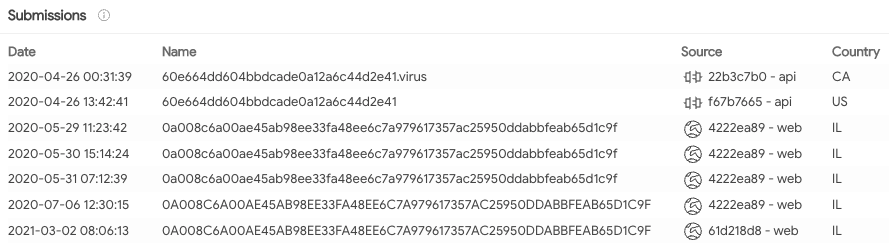

## Script:

In [ ]:
import nest_asyncio
nest_asyncio.apply()
import json
import requests
import vt

QUERIES = [
    VTI_SEARCH
]
RELATIONSHIPS = ["submissions"]
separator = ","
RELATIONSHIPS_URL = separator.join(RELATIONSHIPS)
countries = {}
cities = {}


def get_submission(id, vt_client):
  results = vt_client.get_object(f"/submissions/{id}")
  interface = results.interface
  if interface == "email":
    return False, False, interface
  country = results.country
  if country == "ZZ":
    city = country
  else:
    city = results.city
  return country, city, interface

def get_search_results(query, vt_client):
  """Execute the search and return the results."""
  url = "/intelligence/search"
  results = vt_client.iterator(url, params={"query": query, "relationships": RELATIONSHIPS_URL})
  
  return results



def print_report():
  print("\nTOP targeted countries\n" + "_"*100 + "\n")

  countries_view = [ (v,k) for k,v in countries.items() ]
  countries_view.sort(reverse=True)
  for submission,country in countries_view:
    row = [country,"Number of submissions: ",submission]
    print("{: >15} {: >25} {: >2}".format(*row))

  print("\nTOP targeted cities\n" + "_"*100 + "\n")

  cities_view = [ (v,k) for k,v in cities.items() ]
  cities_view.sort(reverse=True)
  for submission,city in cities_view:
    row = [city,"Number of submissions: ",submission]
    print("{: >35} {: >25} {: >2}".format(*row))

def search_and_hunt(vt_client):
  global countries
  global cities

  for query in QUERIES:
      results = get_search_results(query, vt_client)
      for result in results:       
        positives = result.last_analysis_stats["malicious"]
        for hit in result.relationships["submissions"]["data"]:
          submission_id = hit["id"]
          country,city,interface = get_submission(submission_id, vt_client)

          if interface != "email":
            if country not in countries:
              countries[country] = 0
            countries[country] += 1
            if city not in cities:
              cities[city] = 0
            cities[city] += 1


def main():
  vt_client = vt.Client(API_KEY)
  search_and_hunt(vt_client)
  print_report()

main()

# Use Case: TOP vulnerabilities

In this use case we are going to extract the top exploited vulnerabilities given an intelligence search like the one below:



In [1]:
#@markdown

VTI_SEARCH = 'engines:gandcrab fs:2020-02-01+ fs:2020-05-01- (type:peexe or type:pedll) tag:exploit'  #@param  {type: "string"}

#@markdown 

## Script:

In [ ]:
import nest_asyncio
nest_asyncio.apply()
import json
import requests
import vt

QUERIES = [
    VTI_SEARCH
]
cve_tags = {}


def get_search_results(query, vt_client):
  """Execute the search and return the results."""
  url = "/intelligence/search"
  results = vt_client.iterator(url, params={"query": query})
  
  return results


def search_and_hunt(vt_client):
  global cve_tags

  for query in QUERIES:
    results = get_search_results(query, vt_client)
    for result in results:
      for tag in getattr(result, "tags", []):
        if "cve" in tag:
          if tag not in cve_tags:
            cve_tags[tag] = 0
          cve_tags[tag] += 1

def print_report():
  print("\nTOP Vulnerabilities" + "\n" + "_"*100 + "\n")
  top_view = [ (v,k) for k,v in cve_tags.items() ]
  top_view.sort(reverse=True)
  for v,k in top_view:
      row = [k,"Number of matches: ",v]
      print("{: >15} {: >25} {: >5}".format(*row))

def main():
  vt_client = vt.Client(API_KEY)
  search_and_hunt(vt_client)
  print_report()

main()